# TensorFlow 2.0 Tutorial Part 2

This is a tutorial on the basic to advanced commands in TensorFlow version 2.0.

### Resources:

[1] Official Tensorflow documentation https://www.tensorflow.org/

[2] Tensorflow in Practice Specialization Coursera

### Table of Contents
   
- [Models](#models)
   - [Transfer Learning](#transfer)
   - [Convolutional Neural Networks](#cnn) 
   - [Natural Language Processing](#nlp) 
   - [Recurrent Neural Networks](#recurrent)
   - [Generative Models](#generative)

### Examples of different Deep Learning Models 
<a name="models">

### Convolutional Neural Network + Transfer Learning
<a name="transfer">

In [1]:
import tensorflow as tf
import os 
import zipfile 


zip_dataset = zipfile.ZipFile('dataset/horse-or-human.zip','r')
zip_dataset.extractall('dataset/horse-or-human/train')
zip_dataset.close()


valid_zip_dataset = zipfile.ZipFile('dataset/validation-horse-or-human.zip', 'r')
valid_zip_dataset.extractall('dataset/horse-or-human/validation')
valid_zip_dataset.close()


base_dir = '/dataset/horse-or-human'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training horse/human pictures
train_horse_dir = os.path.join(train_dir, 'horse')
train_human_dir = os.path.join(train_dir, 'human')

# Directory with our validation horse/human pictures
validation_horse_dir = os.path.join(validation_dir, 'horse')
validation_human_dir = os.path.join(validation_dir, 'human')

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define our example directories and files
train_dir = 'dataset/horse-or-human/train'
validation_dir = 'dataset/horse-or-human/validation'

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

# Expected Output:
# Found 1027 images belonging to 2 classes.
# Found 256 images belonging to 2 classes.

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [8]:
from tensorflow.keras.optimizers import RMSprop

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18496)            

In [3]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.95):
            print("\nReached 99.9% accuracy so cancelling training!")
            self.model.stop_training = True

In [10]:
callbacks = myCallback()
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 100,
            validation_steps = 50,
            verbose = 2,
            callbacks=[callbacks])

Epoch 1/100
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
100/100 - 35s - loss: 0.6177 - accuracy: 0.6596 - val_loss: 1.2890 - val_accuracy: 0.5132
Epoch 2/100
100/100 - 35s - loss: 0.4931 - accuracy: 0.7690 - val_loss: 1.4482 - val_accuracy: 0.5557
Epoch 3/100


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
# Convolutional Neural Network with Transfer Learning (Inception Net)

In [4]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
    layer.trainable = False

# Print the model summary
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [5]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [6]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.95):
            print("\nReached 99.9% accuracy so cancelling training!")
            self.model.stop_training = True

In [7]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers
from tensorflow.keras import Model


# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [8]:
callbacks = myCallback()
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 100,
            validation_steps = 50,
            verbose = 2,
            callbacks=[callbacks])

Epoch 1/100
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
100/100 - 143s - loss: 0.1989 - accuracy: 0.9260 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 2/100

Reached 99.9% accuracy so cancelling training!
100/100 - 137s - loss: 0.0655 - accuracy: 0.9772 - val_loss: 0.0349 - val_accuracy: 0.9889


<Figure size 432x288 with 0 Axes>

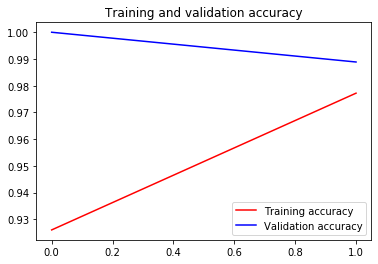

<Figure size 432x288 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt

%matplotlib inline

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

### Convolutional Neural Networks 
<a name="cnn">

In [1]:
import os
import zipfile

zip_ref = zipfile.ZipFile('dataset/cats_and_dogs_filtered.zip', 'r')
zip_ref.extractall('dataset/cats_and_dogs_filtered')
zip_ref.close()

In [2]:
base_dir = 'dataset/cats_and_dogs_filtered/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [3]:
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )

print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.101.jpg', 'cat.102.jpg', 'cat.103.jpg', 'cat.104.jpg', 'cat.105.jpg', 'cat.106.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


In [4]:
print('total training cat images :', len(os.listdir(      train_cats_dir ) ))
print('total training dog images :', len(os.listdir(      train_dogs_dir ) ))

print('total validation cat images :', len(os.listdir( validation_cats_dir ) ))
print('total validation dog images :', len(os.listdir( validation_dogs_dir ) ))

total training cat images : 1000
total training dog images : 1000
total validation cat images : 500
total validation dog images : 500


In [6]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

In [7]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [9]:
history = model.fit(train_generator,
                              validation_data=validation_generator,
                              steps_per_epoch=100,
                              epochs=15,
                              validation_steps=50,
                              verbose=2)

Epoch 1/15
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
100/100 - 27s - loss: 0.7784 - accuracy: 0.5565 - val_loss: 0.6783 - val_accuracy: 0.5710
Epoch 2/15
100/100 - 31s - loss: 0.6432 - accuracy: 0.6540 - val_loss: 0.8511 - val_accuracy: 0.5400
Epoch 3/15
100/100 - 32s - loss: 0.5555 - accuracy: 0.7245 - val_loss: 0.5908 - val_accuracy: 0.6880
Epoch 4/15
100/100 - 30s - loss: 0.4619 - accuracy: 0.7815 - val_loss: 0.5713 - val_accuracy: 0.7310
Epoch 5/15
100/100 - 31s - loss: 0.3708 - accuracy: 0.8360 - val_loss: 0.8158 - val_accuracy: 0.6650
Epoch 6/15
100/100 - 30s - loss: 0.2857 - accuracy: 0.8735 - val_loss: 0.6558 - val_accuracy: 0.7200
Epoch 7/15
100/100 - 30s - loss: 0.2273 - accuracy: 0.9115 - val_loss: 0.7199 - val_accuracy: 0.7310
Epoch 8/15
100/100 - 31s - loss: 0.1696 - accuracy: 0.9370 - val_loss: 0.8010 - val_accuracy: 0.7330
Epoch 9/15
100/100 - 31s - loss: 0.1290 - accuracy: 0.9500 - val_loss: 0.9635 - val_accuracy: 0.71

<Figure size 432x288 with 0 Axes>

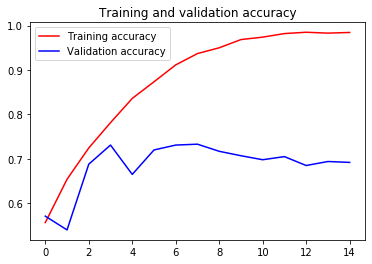

<Figure size 432x288 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt

%matplotlib inline

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

### Natural Language Processing
<a name="nlp">

In [31]:
import csv
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

corpus = []

with open("dataset/bbc-text.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        list_item=[]
        list_item.append(row[0])
        #labels.append(row[0])
        sentence = row[1]
        for word in stopwords:
            token = " " + word + " "
            sentence = sentence.replace(token, " ")
            sentence = sentence.replace("  ", " ")
        list_item.append(sentence)
        #sentences.append(sentence)
        corpus.append(list_item)

import random
random.shuffle(corpus)

In [2]:
# # Note this is the 100 dimension version of GloVe from Stanford
# # I unzipped and hosted it on my site to make this notebook easier
# !wget --no-check-certificate \
#     https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
#     -O /tmp/glove.6B.100d.txt
# embeddings_index = {};
# with open('/tmp/glove.6B.100d.txt') as f:
#     for line in f:
#         values = line.split();
#         word = values[0];
#         coefs = np.asarray(values[1:], dtype='float32');
#         embeddings_index[word] = coefs;

# embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
# for word, i in word_index.items():
#     embedding_vector = embeddings_index.get(word);
#     if embedding_vector is not None:
#         embeddings_matrix[i] = embedding_vector;

In [32]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .8


sentences = []
labels = []

for x in range(len(corpus)):
    sentences.append(corpus[x][1])
    labels.append(corpus[x][0])

    
train_size = int(len(corpus) * training_portion)

train_sentences = sentences[:train_size]
train_labels = labels[:train_size]

validation_sentences = sentences[train_size:]
validation_labels = labels[train_size:]


tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

In [33]:
import numpy as np

label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))


In [34]:
import tensorflow as tf

# model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(6, activation='relu'),
#     tf.keras.layers.Dense(6, activation='softmax')
# ])

# with GLoVe Embeddings matrix
# model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Conv1D(64, 5, activation='relu'),
#     tf.keras.layers.MaxPooling1D(pool_size=4),
#     tf.keras.layers.LSTM(64),
#     tf.keras.layers.Dense(6, activation='softmax')
# ])

# Model Definition with Multi layer LSTM
# model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(tokenizer.vocab_size, 64),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dense(6, activation='softmax')
# ])

# Model Definition with GRU
# model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
#     tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
#     tf.keras.layers.Dense(6, activation='relu'),
#     tf.keras.layers.Dense(6, activation='softmax')
# ])


# Model Definition with LSTM
# model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
#     tf.keras.layers.Dense(6, activation='relu'),
#     tf.keras.layers.Dense(6, activation='softmax')
# ])



# Model Definition with Conv1D
# model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
#     tf.keras.layers.Conv1D(128, 10, activation='relu'),
#     tf.keras.layers.GlobalAveragePooling1D(),
#     tf.keras.layers.Dense(6, activation='relu'),
#     tf.keras.layers.Dense(6, activation='softmax')
# ])

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()





Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 6)                 11526     
_________________________________________________________________
dense_13 (Dense)             (None, 6)                 42        
Total params: 171,568
Trainable params: 171,568
Non-trainable params: 0
_________________________________________________________________


In [28]:
num_epochs = 30
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Train on 1780 samples, validate on 445 samples
Epoch 1/30
1780/1780 - 0s - loss: 1.7550 - accuracy: 0.2348 - val_loss: 1.6799 - val_accuracy: 0.2697
Epoch 2/30
1780/1780 - 0s - loss: 1.4803 - accuracy: 0.3365 - val_loss: 1.3791 - val_accuracy: 0.3955
Epoch 3/30
1780/1780 - 0s - loss: 1.0089 - accuracy: 0.6326 - val_loss: 0.9845 - val_accuracy: 0.6157
Epoch 4/30
1780/1780 - 0s - loss: 0.5692 - accuracy: 0.9404 - val_loss: 0.7124 - val_accuracy: 0.7775
Epoch 5/30
1780/1780 - 0s - loss: 0.3018 - accuracy: 0.9933 - val_loss: 0.5489 - val_accuracy: 0.8292
Epoch 6/30
1780/1780 - 0s - loss: 0.1429 - accuracy: 0.9983 - val_loss: 0.4572 - val_accuracy: 0.8562
Epoch 7/30
1780/1780 - 0s - loss: 0.0676 - accuracy: 1.0000 - val_loss: 0.4107 - val_accuracy: 0.8607
Epoch 8/30
1780/1780 - 0s - loss: 0.0371 - accuracy: 1.0000 - val_loss: 0.3869 - val_accuracy: 0.8629
Epoch 9/30
1780/1780 - 0s - loss: 0.0235 - accuracy: 1.0000 - val_loss: 0.3726 - val_accuracy: 0.8652
Epoch 10/30
1780/1780 - 0s - loss: 

<Figure size 432x288 with 0 Axes>

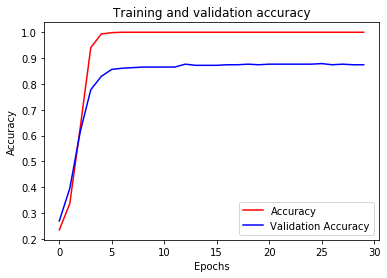

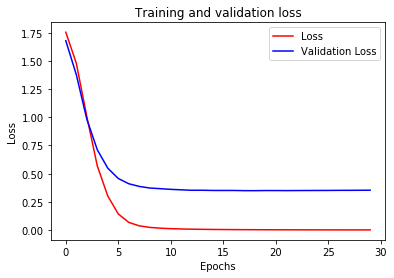

<Figure size 432x288 with 0 Axes>

In [29]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

%matplotlib inline
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()

In [30]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(train_padded[3]))
print(train_sequences[3])

<OOV> full back captain agree can t captain full back said campese need someone <OOV> action s hard give orders way back there people leaders aren t s not s no one stands england s pack no clear cut leaders campese though defended coach andy robinson believes choice sir clive woodward s resignation blamed lack talent england camp making current coach look poor england face potential wooden spoon match italy 12 march ex <OOV> added england lost d bloody <OOV> said don t think will campese tipped wales win six nations grand slam come end tournament s surprising tournament said maybe ireland little bit talent overall playing home major boost possible grand slam decider millennium stadium will just much irish
[6092, 1, 9740, 63, 135, 614, 2141, 323, 6092, 28, 63, 574, 9740, 2798, 1069, 225, 63, 428, 804, 778, 1, 1539, 1962, 4550, 9741, 32, 1, 1667, 454, 4002, 5360, 3438, 6092, 28, 48, 578, 778, 1316, 63, 2, 2799, 9740, 1, 574, 60, 154, 8669, 171, 1963, 31, 171, 16, 161, 1, 61, 63, 1, 2652,

### Recurrent Neural Networks
<a name="recurrent">

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset


def windowed_dataset_conv1D(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)



In [4]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
conv1D_dataset = windowed_dataset_conv1D(x_train, window_size, batch_size, shuffle_buffer_size)

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()

# model = tf.keras.models.Sequential([
#   tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
#                       input_shape=[None]),
#   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
#   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
#   tf.keras.layers.Dense(1),
#   tf.keras.layers.Lambda(lambda x: x * 10.0)
# ])


model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 10.0)
])


lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(conv1D_dataset, epochs=100, callbacks=[lr_schedule])
# history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
94/94 [==============================] - 4s 40ms/step - loss: 28.1160 - mae: 28.6639
Epoch 2/100
94/94 [==============================] - 2s 19ms/step - loss: 28.0074 - mae: 28.5547
Epoch 3/100
94/94 [==============================] - 2s 18ms/step - loss: 27.8888 - mae: 28.4360
Epoch 4/100
94/94 [==============================] - 2s 18ms/step - loss: 27.7616 - mae: 28.3088
Epoch 5/100
94/94 [==============================] - 2s 18ms/step - loss: 27.6260 - mae: 28.1731
Epoch 6/100
94/94 [==============================] - 2s 18ms/step - loss: 27.4820 - mae: 28.0291
Epoch 7/100
94/94 [==============================] - 2s 18ms/step - loss: 27.3295 - mae: 27.8765
Epoch 8/100
94/94 [==============================] - 2s 18ms/step - loss: 27.1680 - mae: 27.7149
Epoch 9/100
94/94 [==============================] - 2s 18ms/step - loss: 26.9964 - mae: 27.5433
Epoch 10/100
94/94 [=============

94/94 [==============================] - 2s 23ms/step - loss: 16.0824 - mae: 16.6319
Epoch 48/100
94/94 [==============================] - 2s 23ms/step - loss: 14.9339 - mae: 15.4834
Epoch 49/100
94/94 [==============================] - 2s 24ms/step - loss: 13.4531 - mae: 13.9996
Epoch 50/100
94/94 [==============================] - 2s 20ms/step - loss: 11.8119 - mae: 12.3512: 0s - loss: 10.7369 - m
Epoch 51/100
94/94 [==============================] - 2s 21ms/step - loss: 10.2756 - mae: 10.8032
Epoch 52/100
94/94 [==============================] - 2s 20ms/step - loss: 9.1700 - mae: 9.6861: 1s - loss: 
Epoch 53/100
94/94 [==============================] - 2s 20ms/step - loss: 8.5691 - mae: 9.0780
Epoch 54/100
94/94 [==============================] - 2s 20ms/step - loss: 8.2625 - mae: 8.7676
Epoch 55/100
94/94 [==============================] - 2s 21ms/step - loss: 8.0246 - mae: 8.5281
Epoch 56/100
94/94 [==============================] - 2s 20ms/step - loss: 7.7581 - mae: 8.2601
Epoch 

[1e-08, 0.0001, 0, 30]

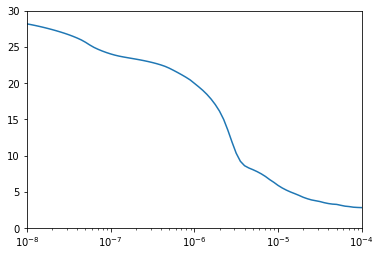

In [8]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

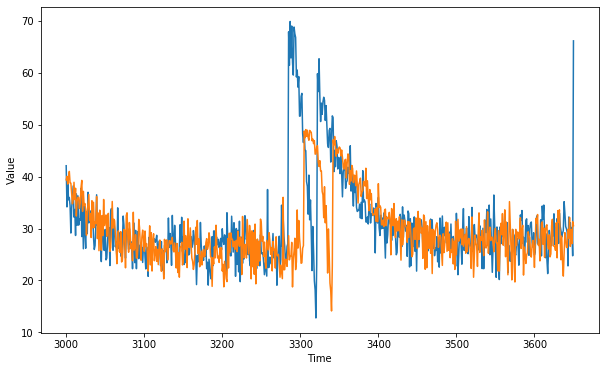

In [9]:
series = tf.expand_dims(series, axis=-1)
forecast = []
results = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [10]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

array([11.186385 , 11.713547 , 10.535592 , 11.364562 , 12.469226 ,
       10.713623 , 10.664399 ,  9.227619 ,  7.71463  ,  8.286745 ,
       10.80435  ,  8.289998 ,  9.91438  ,  6.2410717,  8.033778 ,
        8.601915 ,  8.598758 ,  7.110234 ,  7.8561387, 10.014008 ,
       11.092237 ,  6.7539663,  9.466363 ,  7.489436 ,  7.745592 ,
        6.8601437,  5.1592627,  6.593891 ,  7.6885967,  8.992421 ,
        5.8499017,  6.502986 ,  5.164232 ,  8.132037 ,  5.353206 ,
        7.922202 ,  5.3635244,  5.7171702,  5.6335955,  8.714603 ,
        5.182785 ,  6.578125 ,  5.9279914,  6.9044647,  5.1665134,
        5.876714 ,  6.2960033,  5.1569757,  8.305987 ,  5.4757004,
        6.0590525,  6.3564625,  5.155578 ,  6.1504607,  6.529153 ,
        5.1922207,  6.0025654,  5.6193714,  5.3455367,  8.032557 ,
        5.3420105,  5.9406776,  5.8257527,  5.17851  ,  5.588544 ,
        7.6877785,  5.1911044,  5.240723 ,  6.014714 ,  6.117001 ,
        5.2179403,  7.4157214,  7.149084 ,  5.42311  ,  5.2871

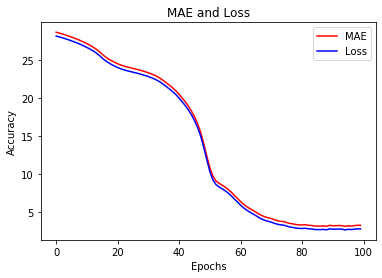

<Figure size 432x288 with 0 Axes>

In [11]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]